Bin's comment:

**NOT COMPLETED**

Last modified on 4/13

In [1]:
import math
import os
import random
import torch
import torch.nn as nn
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import glob
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import SimpleITK as sitk
import torch.optim as optim
import torchvision
from copy import deepcopy

from UNet import UNet4, UNet3, UNet2

c:\Users\tonyz\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class Config():
    batch_size = 16
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    epochs = 6
    warmup = 0.1
    lr = 1e-5
    T_0 = 100  # period of the first restart, we do not want it to restart, so we set it a big number
    T_mult = 1  # period multiplier, it does not matter
    eta_min = lr/10  # minimum learning rate
    len_train_dataloader = None
    len_valid_dataloader = None

In [3]:
# Set SEED here # to be completed

In [3]:
DATASET_PATH = 'dataset'
TRAIN_X_PATH = os.path.join(DATASET_PATH, 'X_train_input')
VALID_X_PATH = os.path.join(DATASET_PATH, 'X_test_input')
TRAIN_Y_PATH = os.path.join(DATASET_PATH, 'X_train_target')
VALID_Y_PATH = os.path.join(DATASET_PATH, 'X_test_target')

In [4]:
len_train = len(os.listdir(TRAIN_X_PATH))
Config.len_train_dataloader = len_train//Config.batch_size
len_train

35340

In [5]:
len_valid = len(os.listdir(VALID_X_PATH))
Config.len_valid_dataloader = len_valid//Config.batch_size
len_valid

8835

The index of TRAIN SET ranges from 0 to 35339 (end included)

The index of VALID SET ranges from 0 to 8834 (end included)

In [6]:
def image_loader(mode, x_or_y, index):
    """
    Return the numpy image given the information.
    mode: 'train', 'valid' or 'test'
    x_or_y: 'x' or 'y', 'x' stands for the input and 'y' stands for the target
    index: int, the index of the image
    """
    if mode == 'train':
        if x_or_y == 'x':
            filepath = os.path.join(TRAIN_X_PATH, os.path.basename(TRAIN_X_PATH)+'_'+str(index)+'.npy')
        if x_or_y == 'y':
            filepath = os.path.join(TRAIN_Y_PATH, os.path.basename(TRAIN_Y_PATH)+'_'+str(index)+'.npy')
    elif mode == 'valid':
        if x_or_y == 'x':
            filepath = os.path.join(VALID_X_PATH, os.path.basename(VALID_X_PATH)+'_'+str(index)+'.npy')
        if x_or_y == 'y':
            filepath = os.path.join(VALID_Y_PATH, os.path.basename(VALID_Y_PATH)+'_'+str(index)+'.npy')
    else:
        raise ValueError("The first or the second parameter is not valid")
        
    if not isinstance(index, int):
        raise TypeError("Index should be an integer")
    
    if mode == 'train' and (index < 0 or index > 35339):
            raise IndexError("Image index out of range 0 - 35339")
            
    if mode == 'valid' and (index < 0 or index > 8834):
            raise IndexError("Image index out of range 0 - 8834")
    
    return np.load(filepath)

In [8]:
img_example = image_loader('valid', 'y', 560)

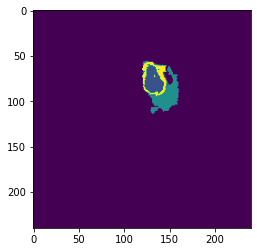

In [9]:
plt.imshow(img_example)

In [10]:
image_loader('train', 'y', 6164).shape

(240, 240)

In [11]:
image_loader('train', 'x', 6164).shape

(240, 240, 4)

**Bin's comment:**

SimpleITK is a widely used package to transform medical images


I dont know whether it is slower than other packages like torchvision transform
You may define other transformation functions and compare them

##### Tony's Comment:
Pytorch seems to work best for data augmentation

In [56]:
# Pytorch version
# --------------------
# This version is fast and more reliable than SITK version
# NEW Applies transformation only p*100% of the time
# NEW [incomplete] does not leave blank artifacts after rotation and translation
# Applies several random tansformations to an image and the label
# - Gaussian blur : image only
# - Rotation : image and label
# - Translation : image and label
def transform(input_array, label_array):
    """
    Data augmentation for training set.
    input_array, label_array are in ndarray
    """

    try:
        # random chance: transformation happens p*100% of the time
        p = 0.25 # default is 0.25
        rand_val = np.random.rand()
        if rand_val > p:
            return input_array, label_array
        
        # set up params
        max_rot = 5             # default is 5
        max_translate = 0.05    # default is 0.05
        sigma_min = 0.01        # default is 0.01
        sigma_max = 1           # default is 1

        # pytorch likes input to be in [C, H, W], so make 4 channels input, 1 channel label
        H,W = label_array.shape
        stacked_layers = np.vstack((input_array, label_array.reshape(1,H,W)))
        stacked_tensor = torch.tensor(stacked_layers)

        # the corner value of each channel is basically guarenteed to be the baseline value, 
        # so use the corner value as the fill value
        fill_vals = [stacked_tensor[c,0,0] for c in range(stacked_tensor.shape[0])]

        # Gaussian blur
        blurT = torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(sigma_min, sigma_max))
        # transformed = blurT.forward(input_tensor).numpy()

        # slight rotation
        rotationT = torchvision.transforms.RandomRotation(degrees = (-1*max_rot,max_rot), fill=fill_vals)
        # transformed = rotationT.forward(input_tensor).numpy()

        # slight translation
        translateT = torchvision.transforms.RandomAffine(degrees=0, translate=(0.0, max_translate), fill=fill_vals)
        # transformed = translateT.forward(input_tensor).numpy()

        # apply transformations
        combinedT = torchvision.transforms.Compose([rotationT, translateT])
        transformed_stacked = combinedT(stacked_tensor)
        transformed_input = transformed_stacked[0:-1, :,:]
        transformed_input = blurT.forward(transformed_input).numpy() # add blur to input
        transformed_label = transformed_stacked[-1, :,:].numpy()

        # turn back into original shape
        # transformed_input_orig = np.array([[transformed_input[:,i,j] for j in range(transformed_input.shape[2])] for i in range(transformed_input.shape[1])])

    except Exception as e:
        transformed_input = input_array
        transformed_label = label_array

    return transformed_input, transformed_label

In [13]:
# SimpleITK Version
# ------------------
# Broken: Use the pytorch version unless this one gets fixed
def transformITK(input_array, label_array):
    """
    Data augmentation for training set.
    input_array, label_array are in ndarray
    """

    # stack input and label so they can be modified togther
    stacked = np.zeros((input_array.shape[0], input_array.shape[1], input_array.shape[2] + 1))
    stacked[:,:,:-1] = input_array
    stacked[:,:,-1] = label_array

    # transform to simpleITK image
    image = sitk.GetImageFromArray(stacked)

    # get info about image
    width, height, depth = image.GetSize()
    image_center =  image.TransformIndexToPhysicalPoint((int(np.ceil(width/2)),
                                          int(np.ceil(height/2)),
                                          int(np.ceil(depth/2))))

    # set transformation parameters
    sigma_max = 0.01
    sigma_min = 1
    rot_max = -5 # in degrees
    rot_min = 5 # in degrees
    trnsl_x_max = 0.5
    trnsl_x_min = -0.5
    trnsl_y_max = 0.5
    trnsl_y_min = -0.5

    sigma = (sigma_max - sigma_min) * np.random.random_sample() + sigma_min
    random_degree = (rot_max - rot_min) * np.random.random_sample() + rot_min
    random_x = (trnsl_x_max - trnsl_x_min) * np.random.random_sample() + trnsl_x_min
    random_y = (trnsl_y_max - trnsl_y_min) * np.random.random_sample() + trnsl_y_min
    translation = (random_x, random_y, 0)

    # preform rotation and translation on both
    rotation_angle = np.deg2rad(random_degree)
    euler_transform = sitk.Euler3DTransform(image_center, rotation_angle, 0, 0, translation)
    reference_image = image
    interpolator = sitk.sitkBSpline
    default_value = 0
    transformed = sitk.Resample(image, reference_image, euler_transform,
                     interpolator, default_value)

    # seperate input and label
    transformed_stacked = sitk.GetArrayFromImage(transformed)
    transformed_input = transformed_stacked[:,:,0:-1]
    transformed_label = transformed_stacked[:,:,-1]

    # preform gaussion blur on only input
    input_image = sitk.GetImageFromArray(transformed_input)
    gaussian = sitk.SmoothingRecursiveGaussianImageFilter()
    gaussian.SetSigma(sigma)
    transformed_image = gaussian.Execute(input_image)
    
    # turn back into numpy array
    transformed_input = sitk.GetArrayFromImage(transformed_image)
    
    return transformed_input, transformed_label

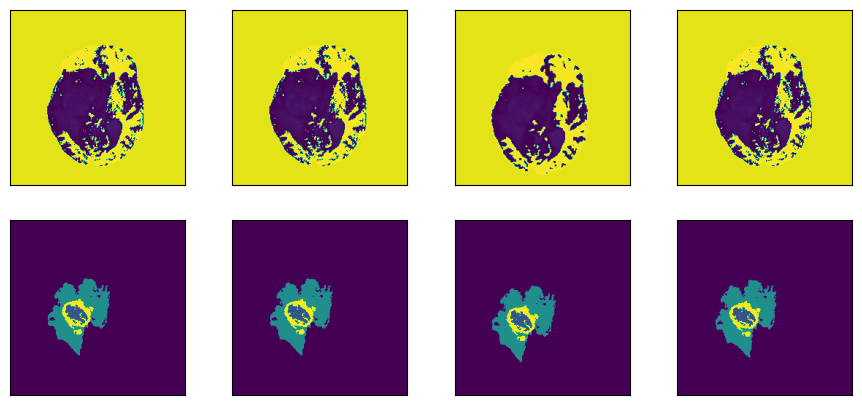

In [57]:
idx = 70

input_array = image_loader('train', 'x', idx)
label_array = image_loader('train', 'y', idx)
img_reordered = input_array.transpose((2, 0, 1))

x1_orig, y1 = transform(img_reordered, label_array)
x2_orig, y2 = transform(img_reordered, label_array)
x3_orig, y3 = transform(img_reordered, label_array)

fig, axs = plt.subplots(2, 4, figsize=(11, 5))
imgs = [input_array[:,:,3], x1_orig[3,:,:], x2_orig[3,:,:], x3_orig[3,:,:], label_array, y1, y2, y3]
imgs = [(img * (255/4)).astype('uint8') for img in imgs]
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


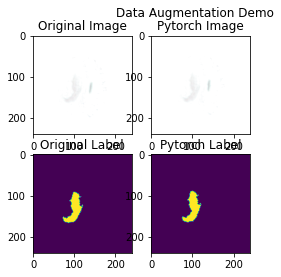

In [15]:
plt.subplot(2,3,1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(2,3,2)
plt.imshow(transformed_input_orig)
plt.title("Pytorch Image")

# plt.subplot(2,3,3)
# plt.imshow(transformed_inputITK)
# plt.title("SITK Image")

plt.subplot(2,3,4)
plt.imshow(label)
plt.title("Original Label")

plt.subplot(2,3,5)
plt.imshow(transformed_label)
plt.title("Pytorch Label")

# plt.subplot(2,3,6)
# plt.imshow(transformed_labelITK)
# plt.title("SITK Label")

plt.suptitle("Data Augmentation Demo")
plt.show()

In [16]:
print(type(transformed_input))
print(transformed_input.dtype)

<class 'numpy.ndarray'>
float32


In [17]:
class TrainDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return len_train

    def __getitem__(self, idx):
        x, y = image_loader('train', 'x', idx), image_loader('train', 'y', idx)
        x = x.transpose((2, 0, 1))
        x, y = transform(x, y)
        return x, y # NOTE the permute, => Batch*Channel*Wright*Height
    
class ValidDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return len_valid

    def __getitem__(self, idx):
        x, y = image_loader('valid', 'x', idx), image_loader('valid', 'y', idx)
        x = x.transpose((2, 0, 1))
        return x,y

train_dataset = TrainDataset()
valid_dataset = ValidDataset()
train_dataloader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)

In [18]:
#Test the model
#net = UNet3(4, 5) # 4 channels, 5 classes (label 3 actually is ingored)
#y = net(torch.randn(8,4,240,240))
#_, y = torch.max(y, 1)
#print(y.size())
#del net, y

In [19]:
#The F1 score is the Dice coefficient of the set of retrieved items and the set of relevant items.

In [20]:
device=Config.device

model = UNet3(4,5)
bestModel = None
bestLoss = 1000000
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=Config.lr)

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=Config.T_0, T_mult=Config.T_mult, eta_min=Config.eta_min)


for epoch in range(Config.epochs):
    print("Epoch "+str(epoch+1)+" start")
    model.train()
    train_bar = tqdm(total=Config.len_train_dataloader)

    for i, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.type(torch.LongTensor).to(device)

        optimizer.zero_grad()


        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        scheduler.step(epoch + i/len(train_dataloader))
        train_bar.update(1)
        
    train_bar.close()

    model.eval()

    valid_bar = tqdm(total=Config.len_valid_dataloader)
    with torch.no_grad():
        valid_loss = 0.0
        total_pred = []
        total_target = []
        for j, (inputs, targets) in enumerate(valid_dataloader):
            inputs, targets = inputs.to(device), targets.type(torch.LongTensor).to(device)

            # forward
            outputs = model(inputs)
            result = torch.argmax(outputs.detach(), dim=1)
            loss = criterion(outputs, targets)
            
            pred_numpy=result.cpu().numpy().flatten().tolist()
            target_numpy=targets.cpu().numpy().flatten().tolist()
            total_pred.append(pred_numpy)
            total_target.append(target_numpy)
            valid_loss += loss.item()
            valid_bar.update(1)
        valid_loss /= (j + 1)
        if valid_loss<bestLoss:
            bestLoss=loss.detach().cpu().item()
            bestModel=deepcopy(model)
            torch.save(bestModel, 'checkpoint.pt')
            print('Check point saved!')
    valid_bar.close()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss:.4f}")
    print('------------------')

print('Training completed, generating the report, may takes minutes')
total_pred = np.concatenate(total_pred)
total_target = np.concatenate(total_target)


Epoch 1 start


  0%|          | 0/2208 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

Check point saved!
Epoch 1, Train Loss: 0.3946, Valid Loss: 0.4416
------------------
Epoch 2 start


  0%|          | 0/2208 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

Check point saved!
Epoch 2, Train Loss: 0.2603, Valid Loss: 0.2733
------------------
Epoch 3 start


  0%|          | 0/2208 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.5091, Valid Loss: 0.3972
------------------
Epoch 4 start


  0%|          | 0/2208 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.5590, Valid Loss: 0.4192
------------------
Epoch 5 start


  0%|          | 0/2208 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

Check point saved!
Epoch 5, Train Loss: 0.0883, Valid Loss: 0.0965
------------------
Epoch 6 start


  0%|          | 0/2208 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

Check point saved!
Epoch 6, Train Loss: 0.0445, Valid Loss: 0.0564
------------------
Training completed, generating the report, may takes minutes


In [21]:
from sklearn.metrics import classification_report
report = classification_report(total_target, total_pred, digits=3, target_names = ['Background', 'NCR/NET', 'ED', 'ET'])
print(report)

              precision    recall  f1-score   support

  Background      0.996     0.999     0.997 502465142
     NCR/NET      0.629     0.453     0.526   1632930
          ED      0.629     0.546     0.584   3624115
          ET      0.784     0.492     0.605   1173813

    accuracy                          0.993 508896000
   macro avg      0.759     0.622     0.678 508896000
weighted avg      0.992     0.993     0.992 508896000

